In [7]:
#   !pip install albumentations==0.4.5

In [8]:
%matplotlib inline
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import numpy as np
import albumentations as A
from albumentations.pytorch import ToTensor
from data.transformations import Transformations
from data.downloader import Downloader
from data.dataloader import Dataloader
from data.utils import cal_mean, cal_std, image_size
from tqdm import tqdm
from model.regularizer import l1_regularization
from model.train import train 
from model.test import val
from model.network import *
import matplotlib.pyplot as plt
from plotter import *
import cv2
from gradcam import *

In [9]:
downloader = Downloader('./data', 'CIFAR10')
sample = downloader.download_sample(train = True)

Files already downloaded and verified


In [10]:
args = {
    'mean': (0.5, 0.5, 0.5),
    'std': (0.5, 0.5, 0.5),
    'train': False
}
args['train'] = True
args['horizontal_flip_prob'] = 0.2
args['vertical_flip_prob'] = 0.0
args['gaussian_blur_prob'] = 0.0
args['rotate_degree'] = 20
args['cutout'] = 0.3
args['cutout_height'] = 16
args['cutout_width'] = 16
args['mean'] = cal_mean(sample)  # calculate mean
args['std'] = cal_std(sample)   # calculate standard deviation
# print(args['mean'])
classes = sample.classes
print(classes)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [11]:
transformations = Transformations(**args)
trainset = downloader.download(transformations)
args['train'] = False
transformations = Transformations(**args)
testset = downloader.download(transformations, train = False)

Files already downloaded and verified
Files already downloaded and verified


In [12]:
batch_size = 64
num_workers = 2
trainloader = Dataloader.getloader(trainset, batch_size, num_workers)
testloader = Dataloader.getloader(testset, batch_size, num_workers, train = False)

In [13]:
cuda = torch.cuda.is_available()
print('GPU Available?', cuda)
device = torch.device("cuda" if cuda else "cpu")
torch.manual_seed(1)
if cuda:
    torch.cuda.manual_seed(1)

GPU Available? True


In [14]:
from torchsummary import summary
model = ResNet18().to(device)  # Create model
# size = image_size(sample)
# print(summary(model, input_size = size))

In [15]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=0.0)
StepLR(optimizer, step_size=25, gamma=0.1)

In [16]:
totalepochs = 50
losses, accuracies = [], []
for epoch in range(1, totalepochs + 1):
    print(f'Epoch {epoch}:')
    train(model, trainloader, device, optimizer, criterion)
    loss, accuracy = val(model, testloader, device, criterion)
    losses.append(loss)
    accuracies.append(accuracy)

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 1:


  0%|          | 0/782 [00:00<?, ?it/s]


Validation set: Average loss: 0.0245, Accuracy: 4185/10000 (41.85%)

Epoch 2:


  0%|          | 0/782 [00:00<?, ?it/s]


Validation set: Average loss: 0.0214, Accuracy: 4997/10000 (49.97%)

Epoch 3:


  0%|          | 0/782 [00:00<?, ?it/s]


Validation set: Average loss: 0.0173, Accuracy: 6069/10000 (60.69%)

Epoch 4:


  0%|          | 0/782 [00:00<?, ?it/s]


Validation set: Average loss: 0.0155, Accuracy: 6565/10000 (65.65%)

Epoch 5:


  0%|          | 0/782 [00:00<?, ?it/s]


Validation set: Average loss: 0.0132, Accuracy: 7051/10000 (70.51%)

Epoch 6:


  0%|          | 0/782 [00:00<?, ?it/s]


Validation set: Average loss: 0.0127, Accuracy: 7217/10000 (72.17%)

Epoch 7:


  0%|          | 0/782 [00:00<?, ?it/s]


Validation set: Average loss: 0.0120, Accuracy: 7487/10000 (74.87%)

Epoch 8:


  0%|          | 0/782 [00:00<?, ?it/s]


Validation set: Average loss: 0.0100, Accuracy: 7802/10000 (78.02%)

Epoch 9:


  0%|          | 0/782 [00:00<?, ?it/s]


Validation set: Average loss: 0.0089, Accuracy: 8041/10000 (80.41%)

Epoch 10:


  0%|          | 0/782 [00:00<?, ?it/s]


Validation set: Average loss: 0.0085, Accuracy: 8189/10000 (81.89%)

Epoch 11:


  0%|          | 0/782 [00:00<?, ?it/s]


Validation set: Average loss: 0.0092, Accuracy: 8084/10000 (80.84%)

Epoch 12:


  0%|          | 0/782 [00:00<?, ?it/s]


Validation set: Average loss: 0.0089, Accuracy: 8152/10000 (81.52%)

Epoch 13:


  0%|          | 0/782 [00:00<?, ?it/s]


Validation set: Average loss: 0.0082, Accuracy: 8305/10000 (83.05%)

Epoch 14:


  0%|          | 0/782 [00:00<?, ?it/s]


Validation set: Average loss: 0.0082, Accuracy: 8405/10000 (84.05%)

Epoch 15:


  0%|          | 0/782 [00:00<?, ?it/s]


Validation set: Average loss: 0.0083, Accuracy: 8337/10000 (83.37%)

Epoch 16:


  0%|          | 0/782 [00:00<?, ?it/s]


Validation set: Average loss: 0.0084, Accuracy: 8392/10000 (83.92%)

Epoch 17:


  0%|          | 0/782 [00:00<?, ?it/s]


Validation set: Average loss: 0.0078, Accuracy: 8473/10000 (84.73%)

Epoch 18:


  0%|          | 0/782 [00:00<?, ?it/s]


Validation set: Average loss: 0.0082, Accuracy: 8511/10000 (85.11%)

Epoch 19:


  0%|          | 0/782 [00:00<?, ?it/s]


Validation set: Average loss: 0.0084, Accuracy: 8494/10000 (84.94%)

Epoch 20:


  0%|          | 0/782 [00:00<?, ?it/s]


Validation set: Average loss: 0.0080, Accuracy: 8542/10000 (85.42%)

Epoch 21:


  0%|          | 0/782 [00:00<?, ?it/s]


Validation set: Average loss: 0.0075, Accuracy: 8609/10000 (86.09%)

Epoch 22:


  0%|          | 0/782 [00:00<?, ?it/s]


Validation set: Average loss: 0.0084, Accuracy: 8566/10000 (85.66%)

Epoch 23:


  0%|          | 0/782 [00:00<?, ?it/s]


Validation set: Average loss: 0.0086, Accuracy: 8540/10000 (85.40%)

Epoch 24:


  0%|          | 0/782 [00:00<?, ?it/s]


Validation set: Average loss: 0.0074, Accuracy: 8662/10000 (86.62%)

Epoch 25:


  0%|          | 0/782 [00:00<?, ?it/s]


Validation set: Average loss: 0.0078, Accuracy: 8670/10000 (86.70%)

Epoch 26:


  0%|          | 0/782 [00:00<?, ?it/s]


Validation set: Average loss: 0.0084, Accuracy: 8589/10000 (85.89%)

Epoch 27:


  0%|          | 0/782 [00:00<?, ?it/s]


Validation set: Average loss: 0.0076, Accuracy: 8677/10000 (86.77%)

Epoch 28:


  0%|          | 0/782 [00:00<?, ?it/s]


Validation set: Average loss: 0.0079, Accuracy: 8671/10000 (86.71%)

Epoch 29:


  0%|          | 0/782 [00:00<?, ?it/s]


Validation set: Average loss: 0.0082, Accuracy: 8634/10000 (86.34%)

Epoch 30:


  0%|          | 0/782 [00:00<?, ?it/s]


Validation set: Average loss: 0.0080, Accuracy: 8656/10000 (86.56%)

Epoch 31:


  0%|          | 0/782 [00:00<?, ?it/s]


Validation set: Average loss: 0.0078, Accuracy: 8695/10000 (86.95%)

Epoch 32:


  0%|          | 0/782 [00:00<?, ?it/s]


Validation set: Average loss: 0.0077, Accuracy: 8755/10000 (87.55%)

Epoch 33:


  0%|          | 0/782 [00:00<?, ?it/s]


Validation set: Average loss: 0.0078, Accuracy: 8705/10000 (87.05%)

Epoch 34:


  0%|          | 0/782 [00:00<?, ?it/s]


Validation set: Average loss: 0.0078, Accuracy: 8758/10000 (87.58%)

Epoch 35:


  0%|          | 0/782 [00:00<?, ?it/s]


Validation set: Average loss: 0.0080, Accuracy: 8698/10000 (86.98%)

Epoch 36:


  0%|          | 0/782 [00:00<?, ?it/s]


Validation set: Average loss: 0.0078, Accuracy: 8753/10000 (87.53%)

Epoch 37:


  0%|          | 0/782 [00:00<?, ?it/s]


Validation set: Average loss: 0.0077, Accuracy: 8749/10000 (87.49%)

Epoch 38:


  0%|          | 0/782 [00:00<?, ?it/s]


Validation set: Average loss: 0.0084, Accuracy: 8693/10000 (86.93%)

Epoch 39:


  0%|          | 0/782 [00:00<?, ?it/s]


Validation set: Average loss: 0.0075, Accuracy: 8814/10000 (88.14%)

Epoch 40:


  0%|          | 0/782 [00:00<?, ?it/s]


Validation set: Average loss: 0.0081, Accuracy: 8786/10000 (87.86%)

Epoch 41:


  0%|          | 0/782 [00:00<?, ?it/s]


Validation set: Average loss: 0.0084, Accuracy: 8741/10000 (87.41%)

Epoch 42:


  0%|          | 0/782 [00:00<?, ?it/s]


Validation set: Average loss: 0.0077, Accuracy: 8784/10000 (87.84%)

Epoch 43:


  0%|          | 0/782 [00:00<?, ?it/s]


Validation set: Average loss: 0.0082, Accuracy: 8787/10000 (87.87%)

Epoch 44:


  0%|          | 0/782 [00:00<?, ?it/s]


Validation set: Average loss: 0.0082, Accuracy: 8783/10000 (87.83%)

Epoch 45:


  0%|          | 0/782 [00:00<?, ?it/s]


Validation set: Average loss: 0.0083, Accuracy: 8786/10000 (87.86%)

Epoch 46:


  0%|          | 0/782 [00:00<?, ?it/s]


Validation set: Average loss: 0.0082, Accuracy: 8769/10000 (87.69%)

Epoch 47:


  0%|          | 0/782 [00:00<?, ?it/s]


Validation set: Average loss: 0.0079, Accuracy: 8781/10000 (87.81%)

Epoch 48:


  0%|          | 0/782 [00:00<?, ?it/s]


Validation set: Average loss: 0.0082, Accuracy: 8794/10000 (87.94%)

Epoch 49:


  0%|          | 0/782 [00:00<?, ?it/s]


Validation set: Average loss: 0.0087, Accuracy: 8744/10000 (87.44%)

Epoch 50:


Loss=0.01 Batch_ID=781 Accuracy=98.31: 100%|██████████| 782/782 [01:09<00:00, 11.31it/s]



Validation set: Average loss: 0.0084, Accuracy: 8763/10000 (87.63%)



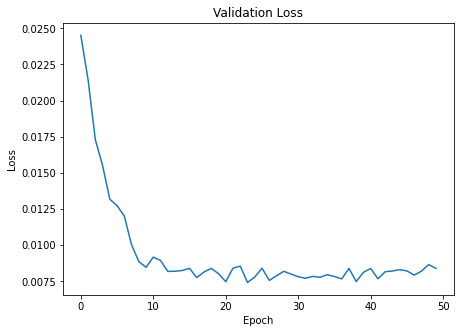

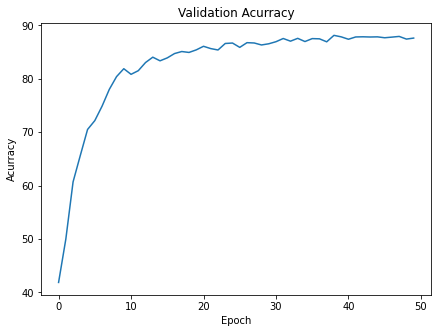

In [17]:
plot_metric(losses, 'Loss')
plot_metric(accuracies, 'Acurracy')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

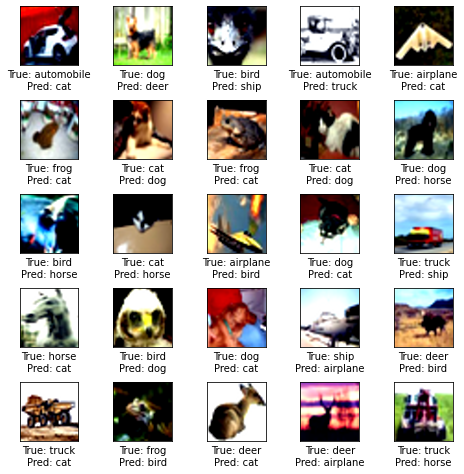

In [27]:

incorrect_images, incorrect_labels, true_labels = get_incorrect_predictions(testloader)
plot_images(5, 5, incorrect_images, classes, true_labels, incorrect_labels)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2941: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Mode set to GradCAM.


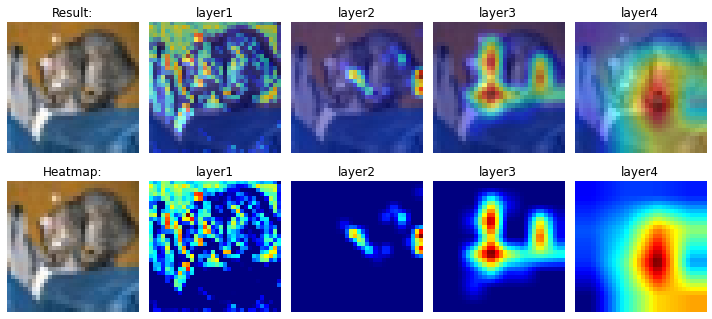

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 432x288 with 0 Axes>

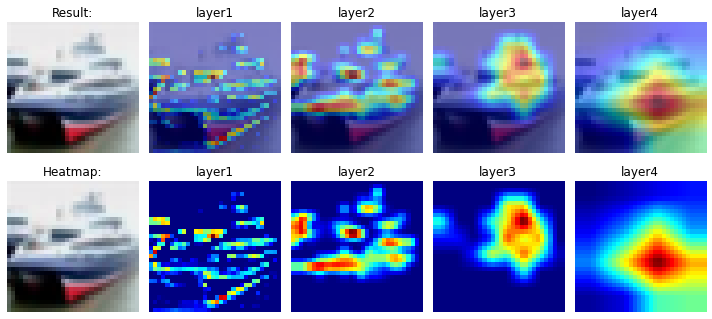

<Figure size 432x288 with 0 Axes>

In [28]:

correct_samples, labels = get_correct_samples(testloader)
# correct_samples = np.array(correct_samples)
grad_cam = GradCAMView(
    model, ['layer1', 'layer2', 'layer3', 'layer4'],
    device, args['mean'], args['std']
)

# images = [x['image'] for x in random.sample(correct_samples, 4)]
grad_cam(correct_samples, 'grad_cam')